In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#Getting rid of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# CSV file
data = pd.read_csv('IoT Network Intrusion Dataset.csv')

In [3]:
# Display basic information
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625783 entries, 0 to 625782
Data columns (total 86 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Flow_ID            625783 non-null  object 
 1   Src_IP             625783 non-null  object 
 2   Src_Port           625783 non-null  int64  
 3   Dst_IP             625783 non-null  object 
 4   Dst_Port           625783 non-null  int64  
 5   Protocol           625783 non-null  int64  
 6   Timestamp          625783 non-null  object 
 7   Flow_Duration      625783 non-null  int64  
 8   Tot_Fwd_Pkts       625783 non-null  int64  
 9   Tot_Bwd_Pkts       625783 non-null  int64  
 10  TotLen_Fwd_Pkts    625783 non-null  float64
 11  TotLen_Bwd_Pkts    625783 non-null  float64
 12  Fwd_Pkt_Len_Max    625783 non-null  float64
 13  Fwd_Pkt_Len_Min    625783 non-null  float64
 14  Fwd_Pkt_Len_Mean   625783 non-null  float64
 15  Fwd_Pkt_Len_Std    625783 non-null  float64
 16  Bw

In [4]:
# Check for missing values
print(data.isnull().sum())

# Handle missing values if any
data = data.dropna() 

Flow_ID     0
Src_IP      0
Src_Port    0
Dst_IP      0
Dst_Port    0
           ..
Idle_Max    0
Idle_Min    0
Label       0
Cat         0
Sub_Cat     0
Length: 86, dtype: int64


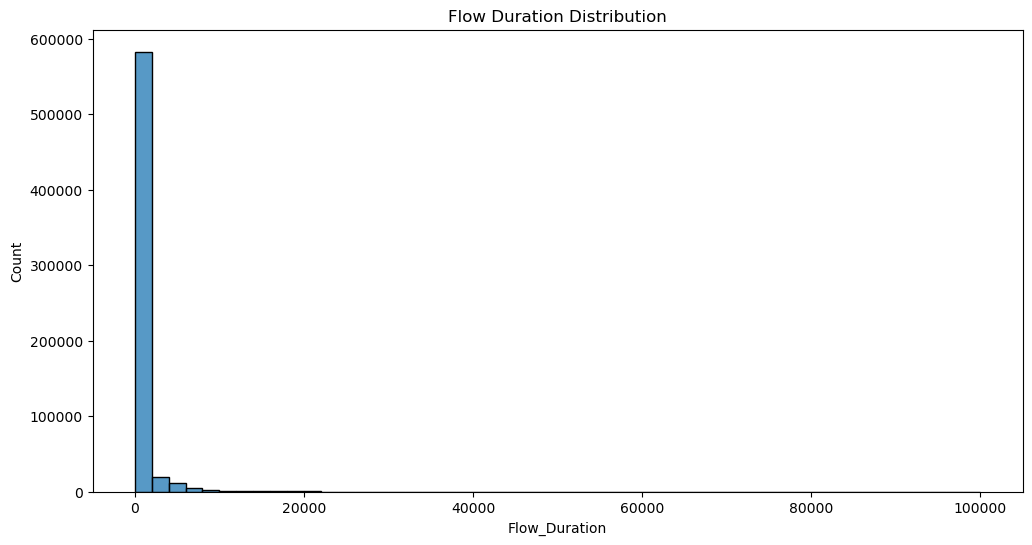

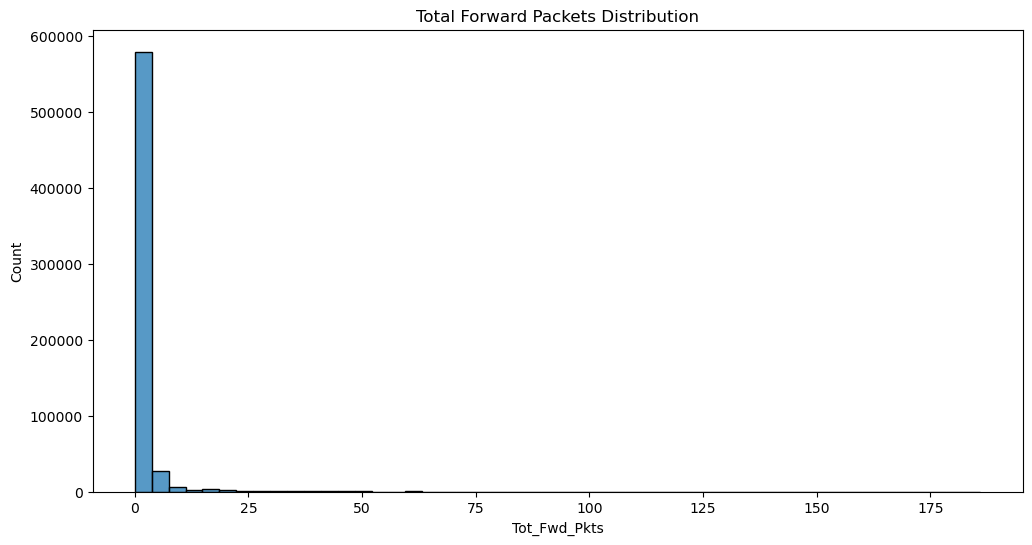

In [5]:
# Plot distributions of some features
plt.figure(figsize=(12, 6))
sns.histplot(data['Flow_Duration'], bins=50)
plt.title('Flow Duration Distribution')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data['Tot_Fwd_Pkts'], bins=50)
plt.title('Total Forward Packets Distribution')
plt.show()

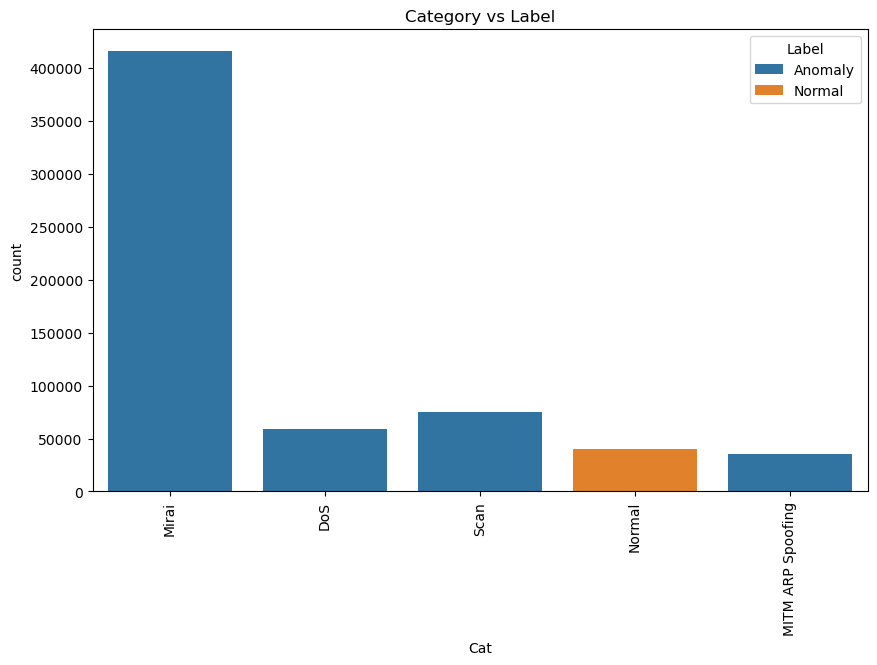

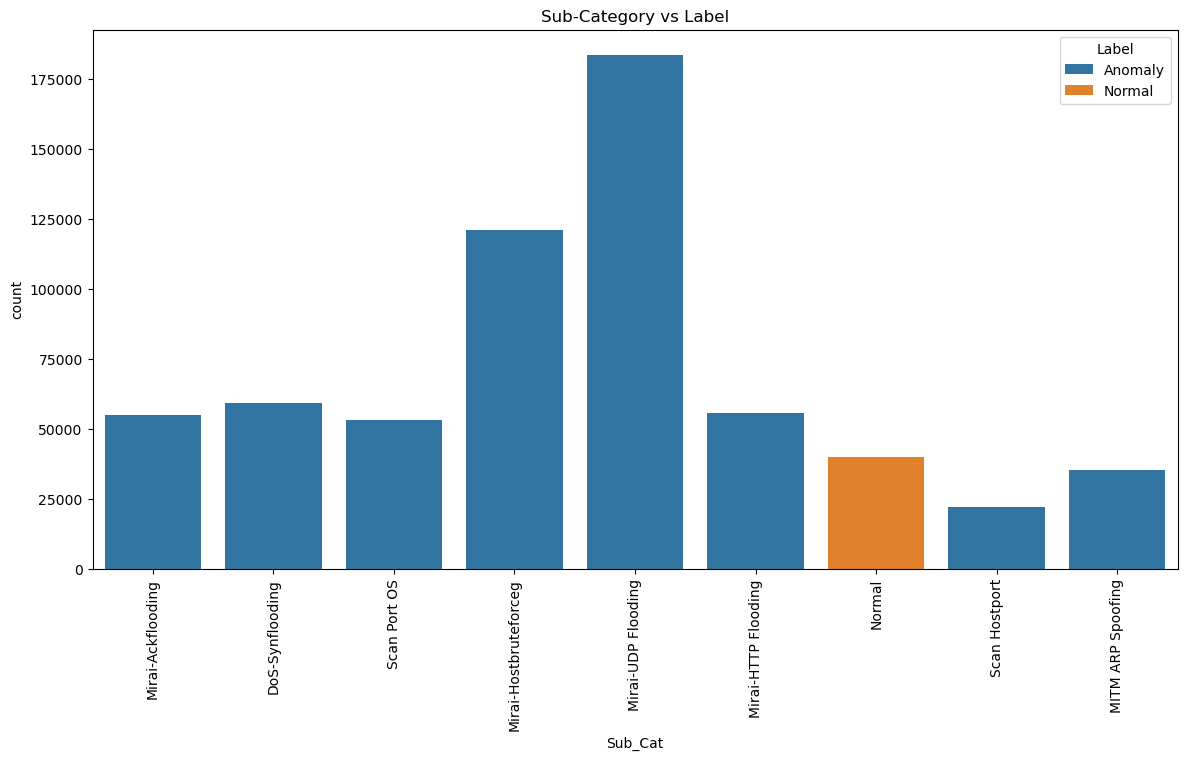

In [6]:
# Countplot of 'Cat' vs 'Label'
plt.figure(figsize=(10, 6))
sns.countplot(x='Cat', hue='Label', data=data)
plt.title('Category vs Label')
plt.xticks(rotation=90)
plt.show()

# Countplot of 'Sub_Cat' vs 'Label'
plt.figure(figsize=(14, 7))
sns.countplot(x='Sub_Cat', hue='Label', data=data)
plt.title('Sub-Category vs Label')
plt.xticks(rotation=90)
plt.show()

In [7]:
# Pivot table for mean values of numerical features across 'Cat'
pivot_cat = data.pivot_table(values=['Flow_Duration', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts'], 
                             index='Cat', aggfunc='mean')
print(pivot_cat)

                   Flow_Duration  Tot_Bwd_Pkts  Tot_Fwd_Pkts
Cat                                                         
DoS                  5377.398242      2.101362      0.212322
MITM ARP Spoofing     116.196144      1.641943      0.616191
Mirai                 124.459725      1.306356      2.213570
Normal                338.393282      1.683727      1.211813
Scan                  117.738896      1.668744      0.603747


In [8]:
# Pivot table for mean values of numerical features across 'Sub_Cat'
pivot_sub_cat = data.pivot_table(values=['Flow_Duration', 'Tot_Fwd_Pkts', 'Tot_Bwd_Pkts'], 
                                 index='Sub_Cat', aggfunc='mean')
print(pivot_sub_cat)

                       Flow_Duration  Tot_Bwd_Pkts  Tot_Fwd_Pkts
Sub_Cat                                                         
DoS-Synflooding          5377.398242      2.101362      0.212322
MITM ARP Spoofing         116.196144      1.641943      0.616191
Mirai-Ackflooding         181.097126      1.372215      1.196575
Mirai-HTTP Flooding       180.636390      1.367588      1.194023
Mirai-Hostbruteforceg     114.805415      1.542915      0.671830
Mirai-UDP Flooding         96.741286      1.111782      3.846873
Normal                    338.393282      1.683727      1.211813
Scan Hostport             118.377659      1.654470      0.642439
Scan Port OS              117.471803      1.674712      0.587568


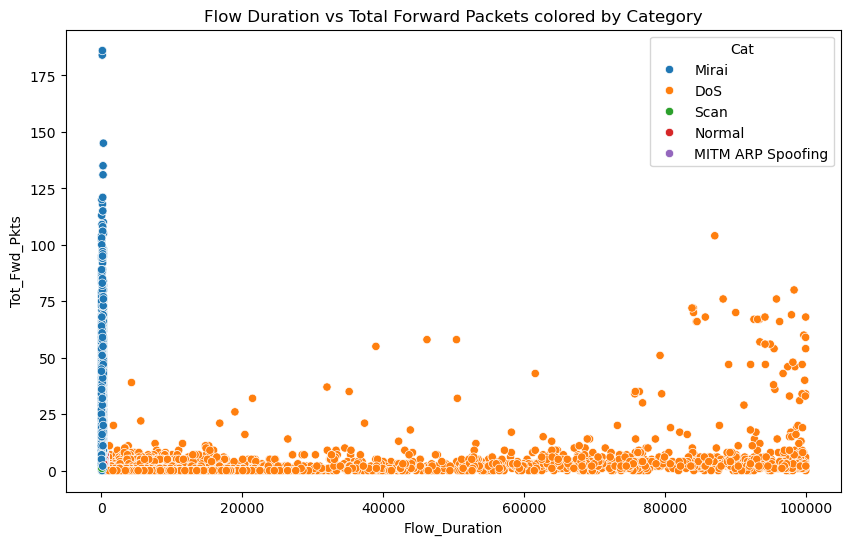

In [9]:
# Scatter plot of 'Flow_Duration' vs 'Tot_Fwd_Pkts' colored by 'Cat'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Flow_Duration', y='Tot_Fwd_Pkts', hue='Cat', data=data)
plt.title('Flow Duration vs Total Forward Packets colored by Category')
plt.show()

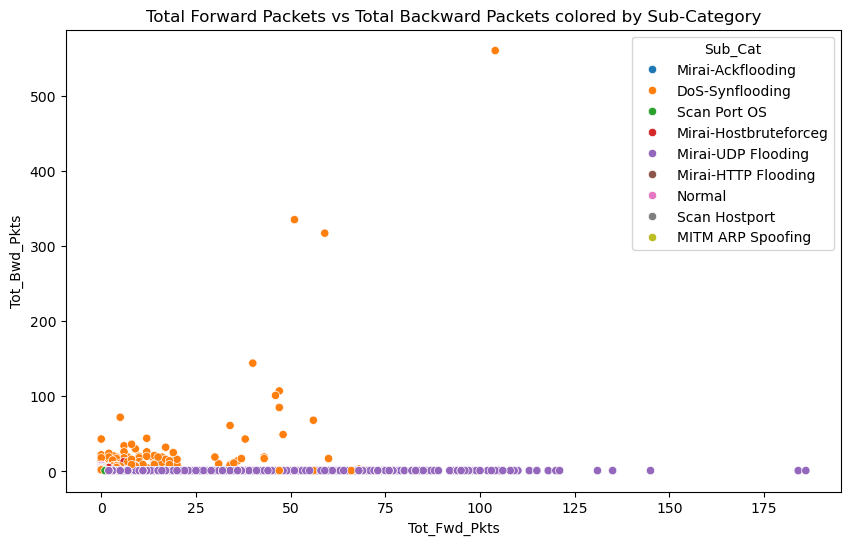

In [10]:
# Scatter plot of 'Tot_Fwd_Pkts' vs 'Tot_Bwd_Pkts' colored by 'Sub_Cat'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tot_Fwd_Pkts', y='Tot_Bwd_Pkts', hue='Sub_Cat', data=data)
plt.title('Total Forward Packets vs Total Backward Packets colored by Sub-Category')
plt.show()

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [12]:
# Check for infinity values
infinity_values = data.replace([np.inf, -np.inf], np.nan)
has_infinity = infinity_values.isna().sum().sum()
print(f'Total infinity values: {has_infinity}')

Total infinity values: 736


In [13]:
# Drop rows containing infinity values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

In [14]:
# Separating features and labels
# Identify non-numeric columns
non_numeric_cols = ['Flow_ID', 'Src_IP', 'Src_Port', 'Dst_IP', 'Dst_Port', 'Protocol', 'Timestamp', 'Label', 'Cat', 'Sub_Cat']

# Extract the features and labels
features = data.drop(columns=non_numeric_cols)
labels = data['Label']

# Standardizing numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Check the shape of the scaled features
scaled_features.shape

(625415, 76)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)

Logisitic Regression Accuracy: 0.9730658842528561
              precision    recall  f1-score   support

     Anomaly       0.98      1.00      0.99    116989
      Normal       0.92      0.64      0.75      8094

    accuracy                           0.97    125083
   macro avg       0.95      0.82      0.87    125083
weighted avg       0.97      0.97      0.97    125083



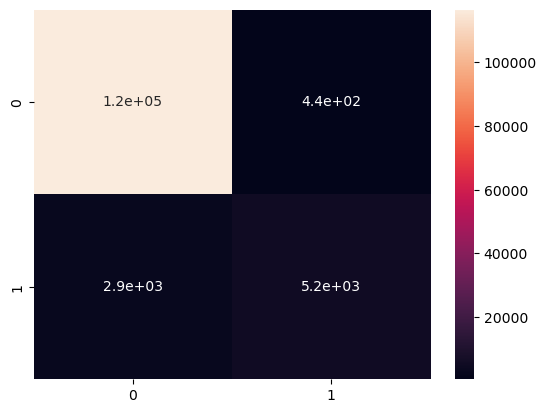

In [16]:
#Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Logisitic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

# Check the confusion matrix of the model
con_m_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(con_m_lr, annot=True)
plt.show()

SVM Accuracy: 0.9838427284283235
              precision    recall  f1-score   support

     Anomaly       0.98      1.00      0.99    116989
      Normal       0.99      0.76      0.86      8094

    accuracy                           0.98    125083
   macro avg       0.98      0.88      0.93    125083
weighted avg       0.98      0.98      0.98    125083



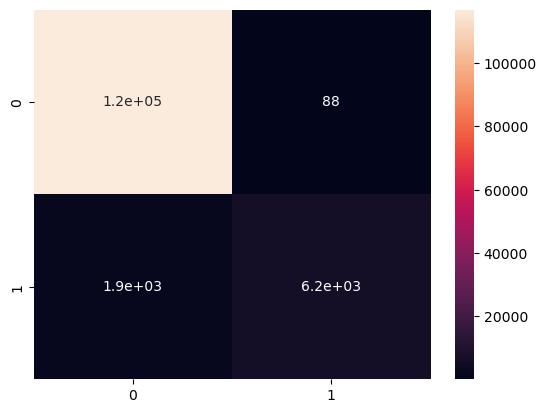

In [17]:
svm_model = SVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Check the confusion matrix of the model
con_m_sv = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(con_m_sv, annot=True)
plt.show()

Random Forest Accuracy: 0.9905582693091787
              precision    recall  f1-score   support

     Anomaly       0.99      1.00      0.99    116989
      Normal       0.97      0.88      0.92      8094

    accuracy                           0.99    125083
   macro avg       0.98      0.94      0.96    125083
weighted avg       0.99      0.99      0.99    125083



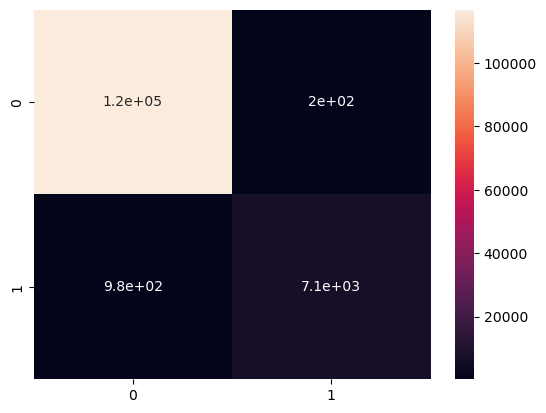

In [18]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Check the confusion matrix of the model
con_m_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(con_m_rf, annot=True)
plt.show()

Naive Bayes Accuracy: 0.5282412478114532
              precision    recall  f1-score   support

     Anomaly       1.00      0.50      0.66    116989
      Normal       0.12      0.99      0.21      8094

    accuracy                           0.53    125083
   macro avg       0.56      0.75      0.44    125083
weighted avg       0.94      0.53      0.63    125083



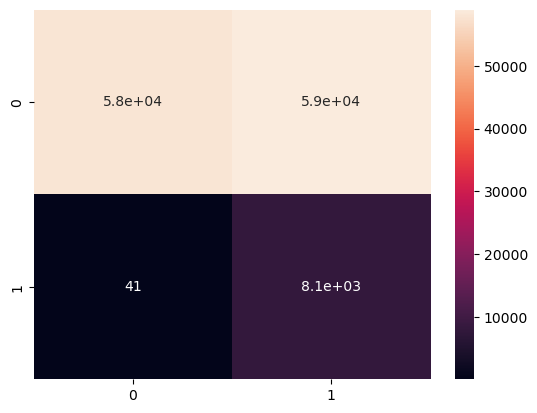

In [19]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# Check the confusion matrix of the model
con_m_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(con_m_nb, annot=True)
plt.show()

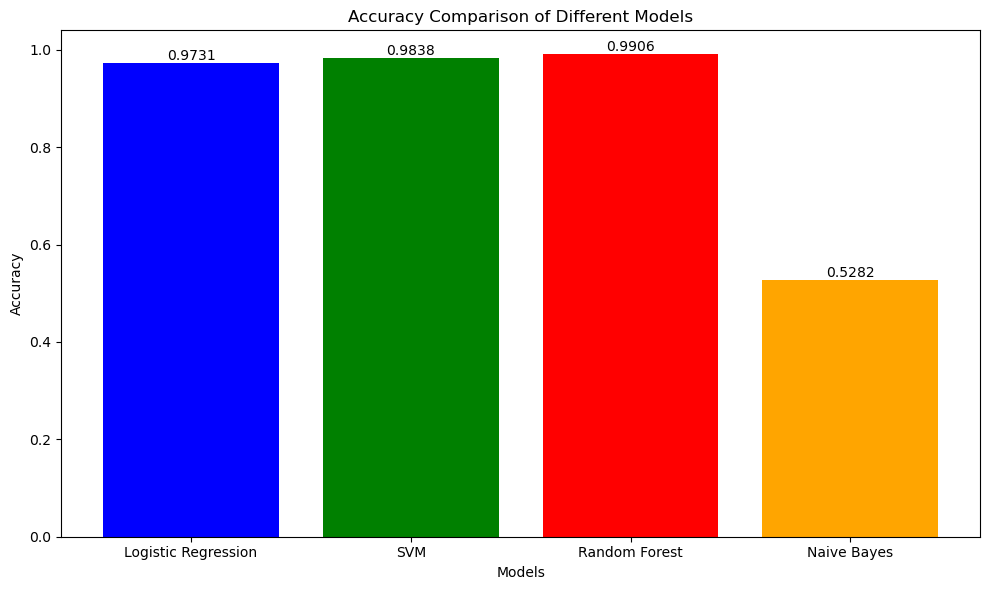

In [20]:
# Accuracy scores
accuracy_scores = [
  accuracy_score(y_test, y_pred_lr),
  accuracy_score(y_test, y_pred_svm),
  accuracy_score(y_test, y_pred_rf),
  accuracy_score(y_test, y_pred_nb)
]

# Model names
model_names = ['Logistic Regression', 'SVM', 'Random Forest', 'Naive Bayes']

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracy_scores, color=['blue', 'green', 'red', 'orange'])

# Add accuracy values on top of bars
for bar, accuracy in zip(bars, accuracy_scores):
  plt.text(bar.get_x() + bar.get_width() / 2, accuracy, f'{accuracy:.4f}', ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')

# Show plot
plt.tight_layout()
plt.show()


In [43]:
#Hyper-parameter Tuning and Cross Validation for best model
dt_param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, None]}
dt_grid_search = GridSearchCV(RandomForestClassifier(), dt_param_grid, cv=5)
dt_grid_search.fit(X_train, y_train)

print("Best Model Parameters:", dt_grid_search.best_params_)

Best Model Parameters: {'criterion': 'gini', 'max_depth': 20}


In [46]:
# Using best parameters for each model
dt_best = dt_grid_search.best_estimator_
# Predictions and evaluations
y_pred_dt_best = dt_best.predict(X_test)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_dt_best))
print(classification_report(y_test, y_pred_dt_best))

Tuned Model Accuracy: 0.9904383489363063
              precision    recall  f1-score   support

     Anomaly       0.99      1.00      0.99    116989
      Normal       0.99      0.87      0.92      8094

    accuracy                           0.99    125083
   macro avg       0.99      0.93      0.96    125083
weighted avg       0.99      0.99      0.99    125083

